# Project: Housing prices in King County

## Imports and download of data

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.formula.api as smf

%matplotlib inline
np.random.seed(42)

In [3]:
df=pd.read_csv("King_County_House_prices_dataset.csv")

## General data structure

In [4]:
df.shape

(21597, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Missing values

In [8]:
missing = pd.DataFrame(df.isnull().sum(), columns = ['Number'])
missing['Percentage']= round((missing.Number/df.shape[0])*100,1)
missing[missing.Number !=0]

,Number,Percentage
waterfront,2376,11.0
view,63,0.3
yr_renovated,3842,17.8


In [9]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [10]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [11]:
df['yr_renovated'].value_counts().head()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

**Thus:** 
 - waterfront, view and yr_renovated have missing values (although only very few for view)
 - Most values of these variables are 0
 - For yr_renovated this might mean "never renovated", but this would then also include many very old houses:

In [13]:
df.groupby(['yr_renovated', 'yr_built']).count()['price'].head(15)

yr_renovated  yr_built
0.0           1900         57
              1901         22
              1902         20
              1903         30
              1904         36
              1905         49
              1906         70
              1907         41
              1908         66
              1909         63
              1910        101
              1911         52
              1912         49
              1913         37
              1914         34
Name: price, dtype: int64

There are also two variables of type 'object': date and sqft_basement:
 - date is a string of the form 'm/d/Y'
 - sqft_basement contains 454 entries with the value '?', so this is also a variable with missing values
 - sqft_basement is 0 for more than half of the entries.
 



**Conclusion:**
The following variables might require some care:
 - waterfront 
 - view 
 - yr_renovated
 - date
 - sqft_basement

## A first look at the data

In [14]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [15]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [16]:
df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287
21596,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,0.0,0.0,...,7,1020,0.0,2008,0.0,98144,47.5941,-122.299,1020,1357


In [17]:
df.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

## Histograms

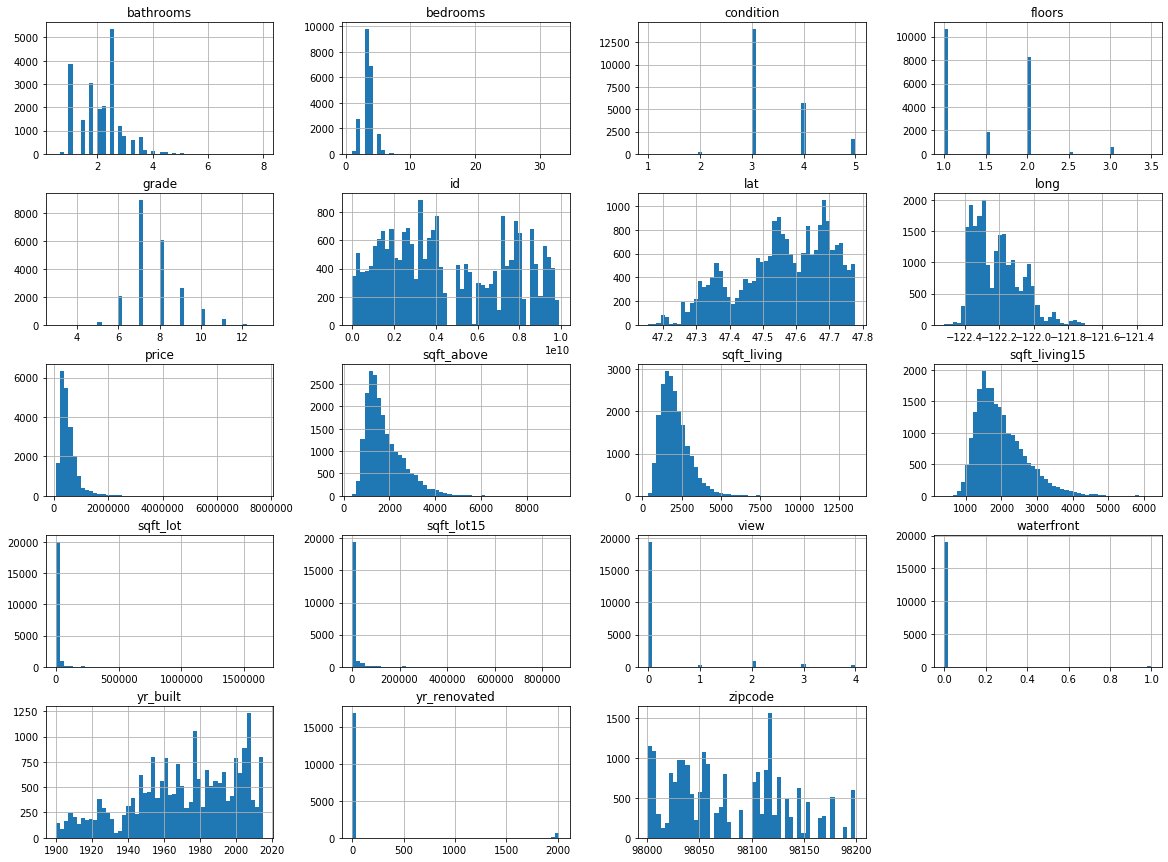

In [18]:
df.hist(bins=50, figsize = (20,15))
plt.show()

**Observations:**
    1. Some variables are very much concentrated around one particular value (0):
     * sqft_lot
     * sqft_lot15
     * view
     * waterfront
     * yr_renovated
    2. No variable seems to be cut off (except the geographical data, which, however, only reflects the border of the county)
    3. The variables price, sqft_above, sqft_living and sqft_living15 have a long tail at high values and 
    are never zero. This suggests to take a logarithm.

## Defining some new useful variables

In [19]:
# Take logs to make the distribution look more normal
df['log_price'] = np.log(df['price'])
df['log_sqft_above'] = np.log(df['sqft_above'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_living15'] = np.log(df['sqft_living15'])

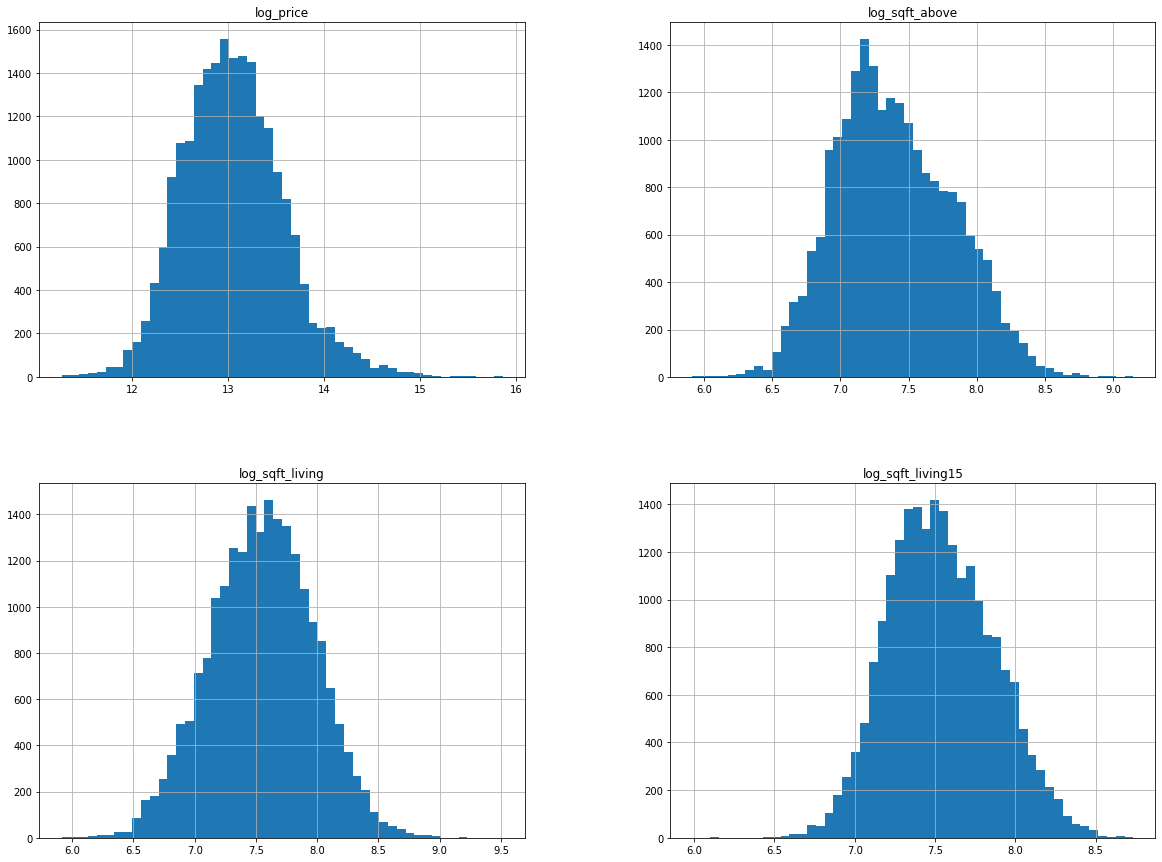

In [25]:
df[['log_price', 'log_sqft_above', 'log_sqft_living', 'log_sqft_living15']].hist(bins=50, figsize = (20,15));

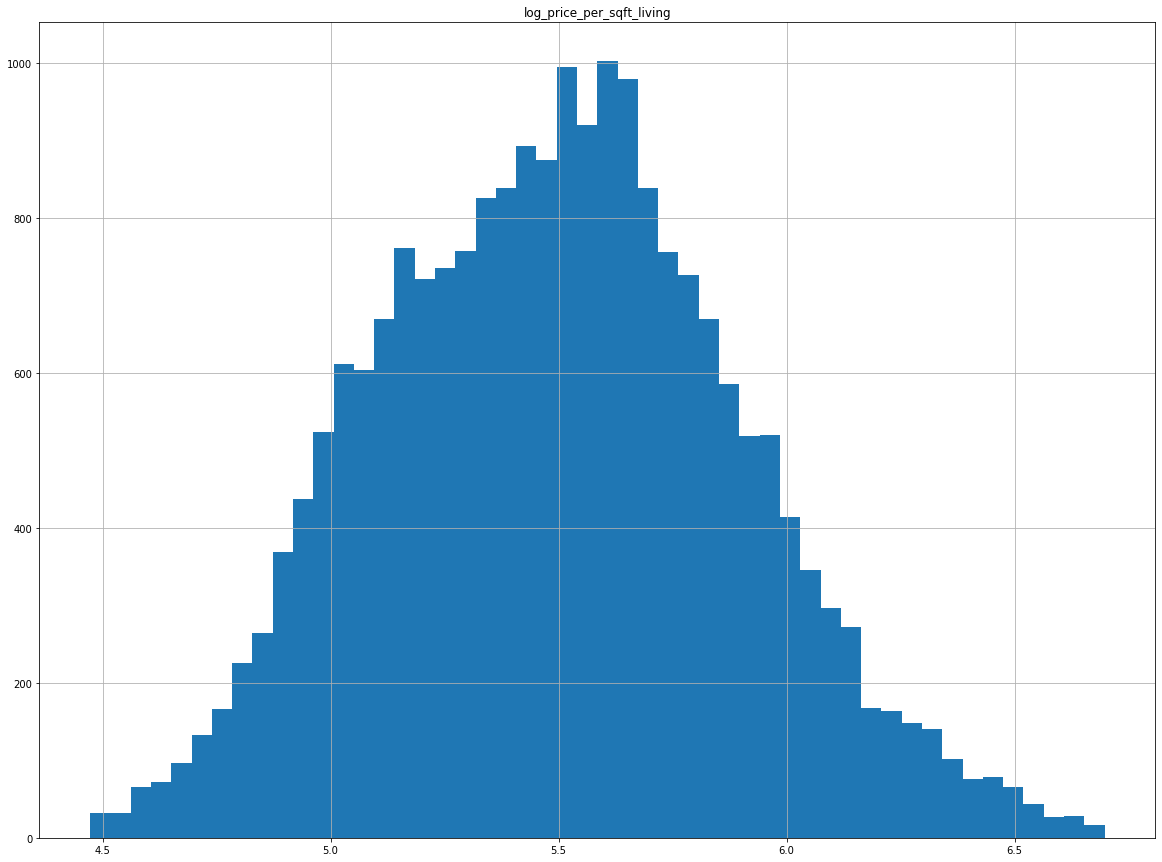

In [53]:
# This variable describes the log of the price per square foot of living area. 
# As it involves the price, we will only use it for plotting but not for evaluation of the model.
df['log_price_per_sqft_living'] = np.log(df['price']/df['sqft_living'])
df[['log_price_per_sqft_living']].hist(bins=50, figsize = (20,15));

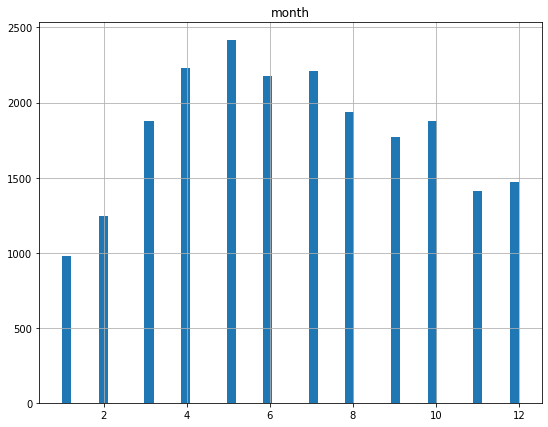

In [273]:
# The selling date is a string of the form 'm/d/Y'. The years in the data set are only from 2014 and 2015 so that
# no long term trends can be read off from them. We thus extract only the month as a possibly interesting 
# variable that could reflect some seasonal variation. The following code is admittedly not very elegant.
df['month']=0
for i in range(len(df)):
    df.loc[i,'month'] = int(df.loc[i,'date'].split('/')[0])

#The histzogram shows a clear seasonal variation (unless the data do not cover full years)    
df[['month']].hist(bins=50, figsize = (9,7)); 


In [55]:
# Check that the new variables are in the table
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,7.200425,5.236712,10
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,47.7210,-122.319,1690,7639,13.195614,7.682482,7.851661,7.432484,5.343953,12
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,7.908387,5.454322,2
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,47.5208,-122.393,1360,5000,13.311329,6.956545,7.580700,7.215240,5.730630,12
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,7.495542,5.715617,2


## Splitting the data into test set and training set


We split the data set into a training set and a test set by defining the function create_train_test,
which cam take a data set and a fraction, which determines the fraction of total data that go into the test set.
We will use as fraction 0.2

In [91]:
def create_train_test(data, rel_test_size):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*rel_test_size)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [92]:
# Make a copy of the data set before we split it (Probably unnecessary)
df2 = df.copy()
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,7.200425,5.236712,10
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,47.7210,-122.319,1690,7639,13.195614,7.682482,7.851661,7.432484,5.343953,12
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,7.908387,5.454322,2
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,47.5208,-122.393,1360,5000,13.311329,6.956545,7.580700,7.215240,5.730630,12
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,7.495542,5.715617,2


In [93]:
train_set, test_set = create_train_test(df2, 0.2)

Some quick checks:

In [94]:
train_set.shape

(17278, 27)

In [95]:
test_set.shape

(4319, 27)

In [99]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
19844,9268850160,2/6/2015,293467.0,4,2.00,1590,942,3.0,0.0,0.0,...,47.5400,-122.026,1390,942,12.589520,7.371489,7.371489,7.237059,5.218031,2
6243,9834201100,12/22/2014,332500.0,4,2.00,1440,4855,2.0,0.0,0.0,...,47.5717,-122.287,1300,4080,12.714395,7.272398,7.272398,7.170120,5.441997,12
8986,7795810110,5/12/2015,390000.0,3,1.75,1430,9857,1.0,0.0,2.0,...,47.4964,-121.771,1310,9880,12.873902,7.038784,7.265430,7.177782,5.608472,5
9419,1853081250,12/29/2014,800000.0,4,2.75,3120,5000,2.0,0.0,0.0,...,47.5940,-122.062,3200,5000,13.592367,8.045588,8.045588,8.070906,5.546779,12
10155,2558630350,3/21/2015,462000.0,4,2.50,2060,6958,1.0,0.0,0.0,...,47.7251,-122.168,1760,7350,13.043320,7.106606,7.630461,7.473069,5.412859,3


In [98]:
test_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
3686,6303401050,2/20/2015,132500.0,3,0.75,850,8573,1.0,0.0,0.0,...,47.5030,-122.356,850,8382,11.794338,6.396930,6.745236,6.745236,5.049102,2
10247,1995200200,10/8/2014,415000.0,3,1.00,1510,6083,1.0,0.0,0.0,...,47.6966,-122.324,1510,5712,12.936034,6.756932,7.319865,7.319865,5.616169,10
4037,1423089118,3/25/2015,494000.0,4,2.25,1790,42000,1.0,0.0,0.0,...,47.4819,-121.744,2060,50094,13.110291,7.064759,7.489971,7.630461,5.620320,3
3437,9349900110,2/17/2015,355000.0,2,1.50,1140,2500,1.0,0.0,1.0,...,47.5707,-122.359,1500,5000,12.779873,6.445720,7.038784,7.313220,5.741090,2
19291,455000395,5/23/2014,606000.0,3,1.00,1500,3920,1.0,0.0,0.0,...,47.6718,-122.359,1640,4017,13.314635,6.907755,7.313220,7.402452,6.001415,5


In [100]:
train_set.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
count,1.727800e+04,1.727800e+04,17278.000000,17278.000000,17278.000000,1.727800e+04,17278.00000,15381.000000,17225.000000,17278.000000,...,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000
mean,4.590787e+09,5.415047e+05,3.374928,2.114553,2083.469730,1.498882e+04,1.49508,0.007672,0.232221,3.410696,...,47.560554,-122.213606,1987.281225,12792.136300,13.049727,7.396374,7.552544,7.539988,5.497183,6.577092
std,2.885123e+09,3.689629e+05,0.904390,0.767659,917.532144,4.019701e+04,0.54105,0.087255,0.765880,0.650809,...,0.138494,0.141549,683.411682,27026.248419,0.527704,0.426813,0.423547,0.327205,0.395229,3.114221
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.00000,0.000000,0.000000,1.000000,...,47.155900,-122.519000,399.000000,651.000000,11.264464,5.913503,5.913503,5.988961,4.472647,1.000000
25%,2.118292e+09,3.238500e+05,3.000000,1.750000,1430.000000,5.060000e+03,1.00000,0.000000,0.000000,3.000000,...,47.471800,-122.329000,1490.000000,5100.000000,12.688036,7.090077,7.265430,7.306531,5.205341,4.000000
50%,3.905030e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.608000e+03,1.50000,0.000000,0.000000,3.000000,...,47.572850,-122.231000,1840.000000,7620.000000,13.017003,7.358831,7.560080,7.517521,5.498988,6.000000
75%,7.334575e+09,6.453750e+05,4.000000,2.500000,2550.000000,1.071900e+04,2.00000,0.000000,0.000000,4.000000,...,47.678300,-122.125000,2360.000000,10089.000000,13.377587,7.705262,7.843849,7.766417,5.763421,9.000000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.50000,1.000000,4.000000,5.000000,...,47.777600,-121.315000,6210.000000,871200.000000,15.856731,9.149528,9.513404,8.733916,6.697206,12.000000


In [102]:
test_set.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
count,4.319000e+03,4.319000e+03,4319.000000,4319.000000,4319.000000,4.319000e+03,4319.000000,3840.000000,4309.000000,4319.000000,...,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000
mean,4.539217e+09,5.354637e+05,3.366288,2.120919,2067.728872,1.554183e+04,1.490160,0.007292,0.240427,3.406344,...,47.558251,-122.215490,1983.976383,12622.856680,13.042145,7.390242,7.543424,7.537516,5.498720,6.561473
std,2.842893e+09,3.609197e+05,1.009282,0.774333,920.397471,4.595760e+04,0.534223,0.085090,0.764965,0.649556,...,0.138785,0.137377,692.532144,28248.335476,0.521949,0.428462,0.426728,0.328546,0.392382,3.118749
min,1.000102e+06,8.300000e+04,1.000000,0.750000,410.000000,6.350000e+02,1.000000,0.000000,0.000000,1.000000,...,47.162200,-122.515000,670.000000,659.000000,11.326596,6.016157,6.016157,6.507278,4.474074,1.000000
25%,2.140000e+09,3.199250e+05,3.000000,1.750000,1410.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,...,47.468250,-122.327000,1490.000000,5059.000000,12.675842,7.081709,7.251345,7.306531,5.207090,4.000000
50%,3.885802e+09,4.500000e+05,3.000000,2.250000,1900.000000,7.630000e+03,1.500000,0.000000,0.000000,3.000000,...,47.569100,-122.229000,1830.000000,7620.000000,13.017003,7.346010,7.549609,7.512071,5.502769,6.000000
75%,7.237375e+09,6.377500e+05,4.000000,2.500000,2520.000000,1.056800e+04,2.000000,0.000000,0.000000,4.000000,...,47.677500,-122.127000,2360.000000,10040.000000,13.365701,7.691657,7.832014,7.766417,5.762944,9.000000
max,9.842300e+09,7.060000e+06,33.000000,7.500000,10040.000000,1.164794e+06,3.000000,1.000000,4.000000,5.000000,...,47.777200,-121.315000,5790.000000,858132.000000,15.769956,8.989694,9.214332,8.663888,6.675423,12.000000


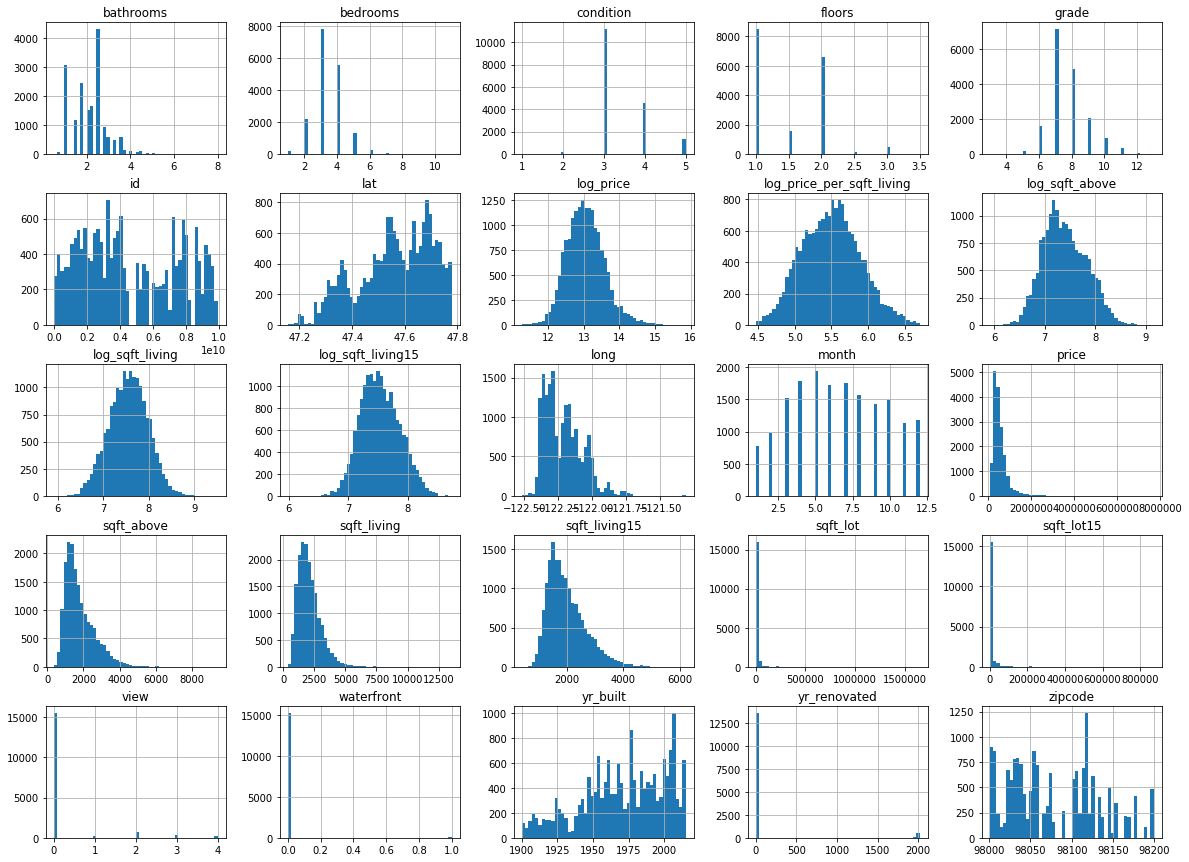

In [103]:
train_set.hist(bins=50, figsize=(20,15))
plt.show()

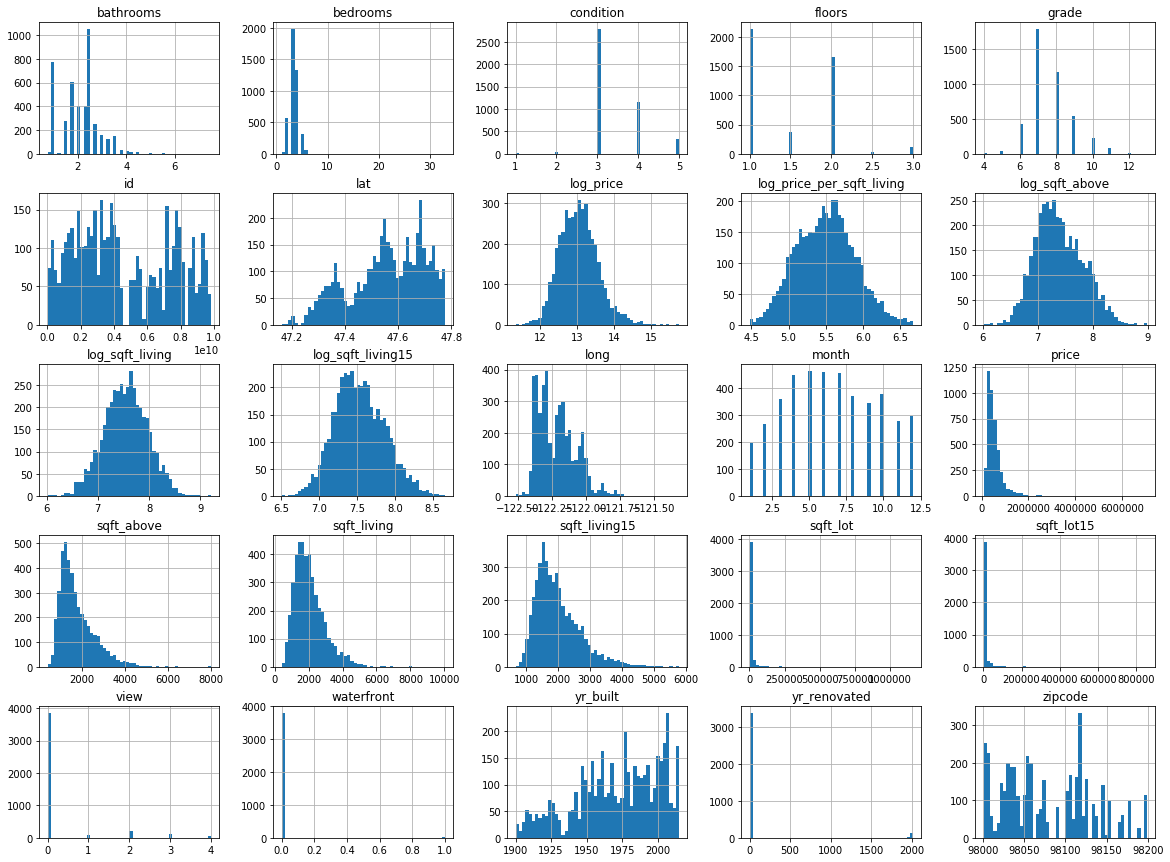

In [104]:
test_set.hist(bins=50,figsize=(20,15))
plt.show()

The histograms look quite similar and similar to the original ones. From now on we only use the train set for the analysis.

## Correlations and scatter plots

In [109]:
corr_matrix = train_set.corr()

In [110]:
corr_matrix['price'].sort_values(ascending=False)

price                        1.000000
log_price                    0.892266
sqft_living                  0.701784
grade                        0.670047
log_sqft_living              0.611965
sqft_above                   0.603073
sqft_living15                0.588636
log_sqft_living15            0.546606
log_sqft_above               0.541521
log_price_per_sqft_living    0.535528
bathrooms                    0.529376
view                         0.400150
bedrooms                     0.315386
lat                          0.305865
waterfront                   0.275385
floors                       0.258392
yr_renovated                 0.129174
sqft_lot                     0.089536
sqft_lot15                   0.078757
yr_built                     0.047720
condition                    0.042932
long                         0.017172
month                       -0.012793
id                          -0.017416
zipcode                     -0.047971
Name: price, dtype: float64

In [111]:
corr_matrix['log_price'].sort_values(ascending=False)

log_price                    1.000000
price                        0.892266
grade                        0.703895
sqft_living                  0.695353
log_sqft_living              0.674826
sqft_living15                0.622665
log_price_per_sqft_living    0.612007
log_sqft_living15            0.610472
sqft_above                   0.600866
log_sqft_above               0.585529
bathrooms                    0.553087
lat                          0.449000
view                         0.349581
bedrooms                     0.347753
floors                       0.312087
waterfront                   0.185843
yr_renovated                 0.120596
sqft_lot                     0.103463
sqft_lot15                   0.091235
yr_built                     0.072492
long                         0.046267
condition                    0.042343
id                          -0.002749
month                       -0.018302
zipcode                     -0.033888
Name: log_price, dtype: float64

log_price has higher correlations with many variables than price, but the other logarithmic variables have 
smaller correlations with log_price or price than the original variables. We will thus from now on use log_price
as the variable to predict and take the other variables without log. Variables such as log_sqft_living will 
nevertheless be useful for plotting. A selection of scatter plots shows that many other variables are also correlated with each other. 

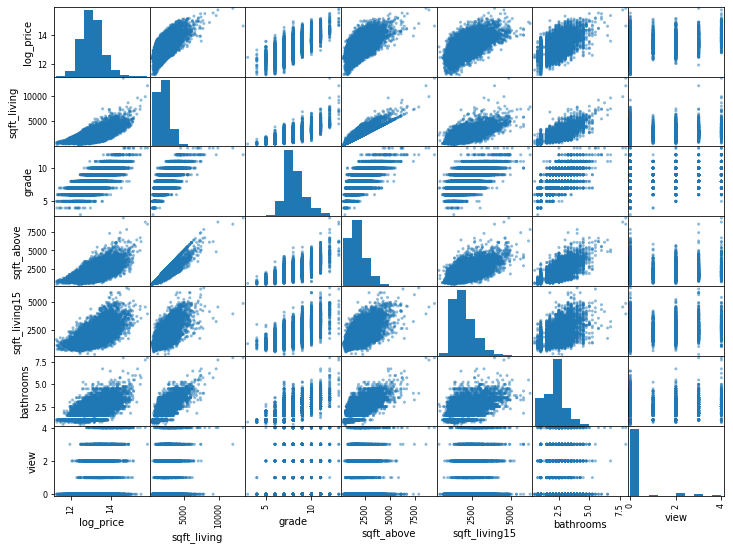

In [114]:
attributes = ['log_price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view']
              #'bedrooms', 'lat', 'waterfront', 'floors', 'yr_renovated']
scatter_matrix(train_set[attributes], figsize = (12,9));

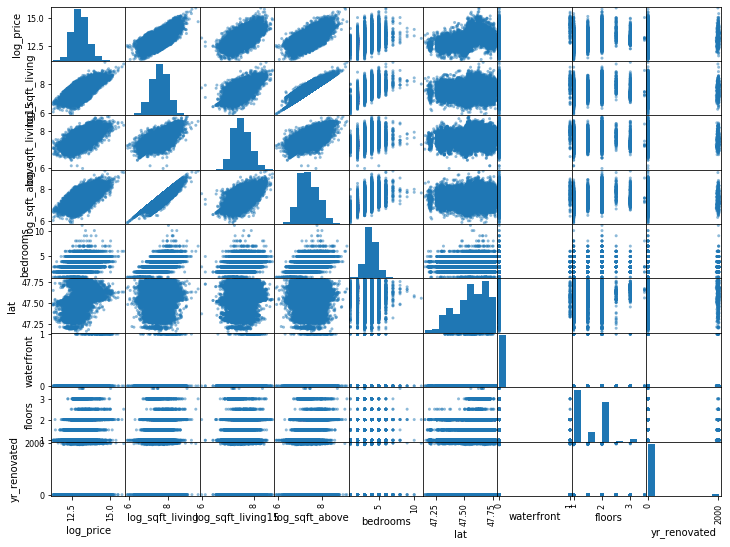

In [118]:
attributes2= ['log_price','log_sqft_living','log_sqft_living15','log_sqft_above', 'bedrooms', 'lat', 'waterfront', 'floors', 'yr_renovated']
scatter_matrix(train_set[attributes2], figsize = (12,9));

## Geographical aspects


### Center distance

Many quantities such as sqft_living, grade etc. have a fairly obvious and not very surprising
correlation with the price. Let us therefore focus here on some less immediate geographical aspects. 
Let us first consider how longitude and latitude relate to the price using scatter plots:
    

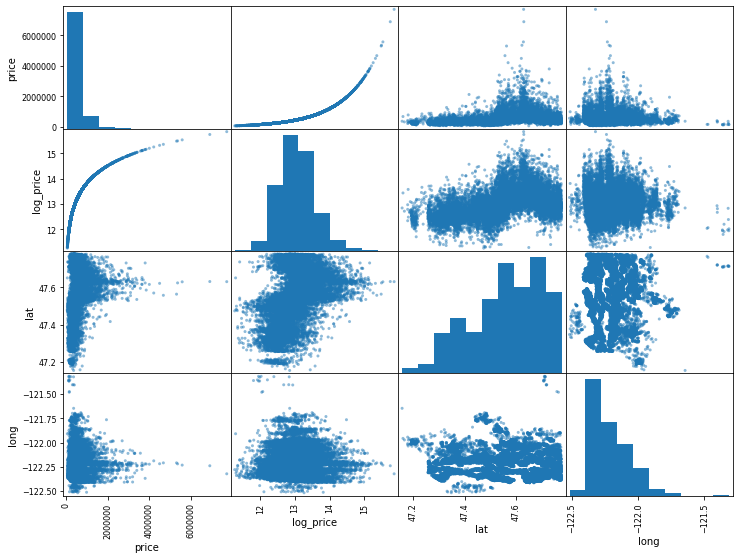

In [120]:
scatter_matrix(train_set[['price','log_price','lat','long']], figsize=(12,9));

The scatter plots of the price (or log_price) with lat and long show that there is some non-trivial structure
that cannot be captured by a linear function. Especially the latitude shows something like a peak at 47.65 degrees,
whereas the longitude has a smaller peak at -122.25 degrees. This could be due to some sort of radial fall-off 
away from a particularly expensive location. 

To get oriented, let us first make a scatter plot of all houses with longitude on the x_axis and latitude 
on the y_axis. We use a color scale to indicate those houses that 
have waterfront = 1 (red) and those that have waterfront = 0 (blue). For better visibility, we have made the 
red dots bigger as well. The red dots thus give a good indicator of where the water areas are located, whereas 
the blue cloud of points tells us where houses were sold, i.e. it should give a rough indicator for the housing
density.


[-122.6, -121.2, 47.1, 47.8]

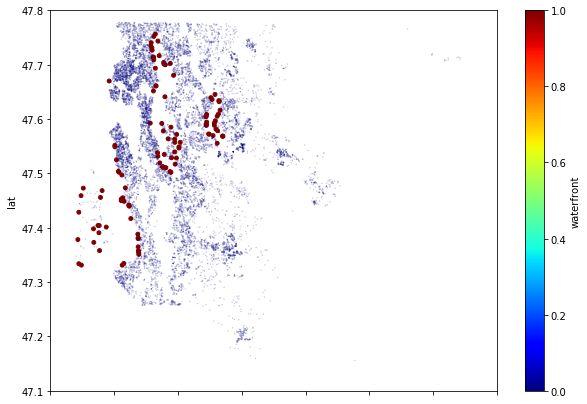

In [121]:
train_set.plot(kind = 'scatter', x= 'long', y='lat',
                   s=15*(train_set['waterfront'])+0.01,c='waterfront', figsize = (10,7), cmap=plt.get_cmap("jet"), colorbar=True)
plt.axis([-122.6,-121.2,47.1,47.8])

Comparing this plot with a map, we recognize Lake Washington and Lake Sammamish between 
47.5 and 47.7 degrees latitude as well as Vashon Island and Puget Sound at the very left.


Let us now for the moment put aside the waterfront variable and plot again long on the x-axis, lat on the y_axis
with color coding for the log_price:

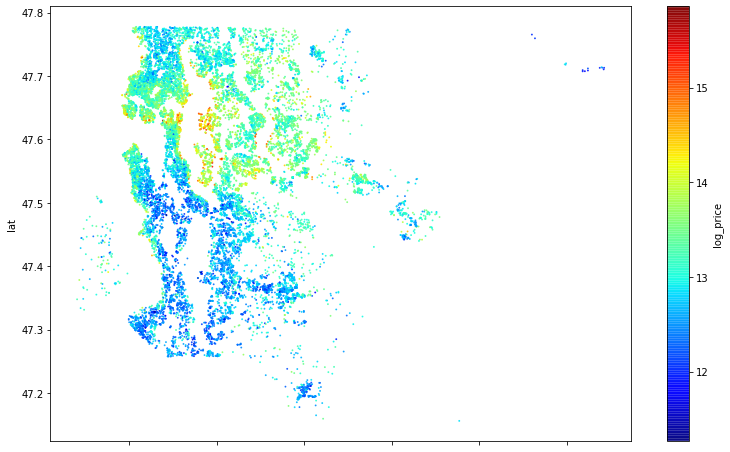

In [123]:
train_set.plot(kind='scatter', x= 'long', y= 'lat', alpha = 0.8, figsize=(13,8), s=0.8, c='log_price', cmap=plt.get_cmap("jet"), colorbar=True);

We see that there is indeed something like a very expensive center with a high density of red dots 
(very expensive) at the eastern part of the center of Lake Washington (an area called "Bellevue"). 
Moreover, the figure suggests a radial fall-of of the log_price with distance from this expensive 
center with an increasing density of blue dots (very cheap) the further out one gets. 

To test this hypothesis quantitatively, we determine the "center" as the median of lat and long
of the most expensive houses (we, somewhat arbitrarily, choose those with a price beyond 3000000 USD):

In [125]:
extremely_expensive_train_set=train_set.query('price>3000000')
extremely_expensive_train_set.shape

(38, 27)

These 38 most expensive houses are indeed located as desired:

[-122.6, -121.2, 47.1, 47.8]

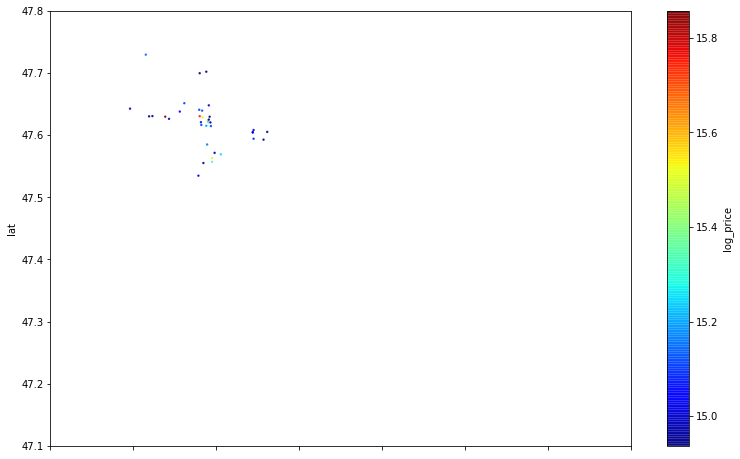

In [131]:
extremely_expensive_train_set.plot(kind='scatter', 
    x= 'long', y= 'lat', alpha = 0.8, figsize=(13,8), s=2, c='log_price', 
    cmap=plt.get_cmap("jet"), colorbar=True);
plt.axis([-122.6,-121.2,47.1,47.8])

In [130]:
extremely_expensive_train_set[['lat','long']].median()

lat      47.6219
long   -122.2230
dtype: float64

In [162]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month
19844,9268850160,2/6/2015,293467.0,4,2.00,1590,942,3.0,0.0,0.0,...,47.5400,-122.026,1390,942,12.589520,7.371489,7.371489,7.237059,5.218031,2
6243,9834201100,12/22/2014,332500.0,4,2.00,1440,4855,2.0,0.0,0.0,...,47.5717,-122.287,1300,4080,12.714395,7.272398,7.272398,7.170120,5.441997,12
8986,7795810110,5/12/2015,390000.0,3,1.75,1430,9857,1.0,0.0,2.0,...,47.4964,-121.771,1310,9880,12.873902,7.038784,7.265430,7.177782,5.608472,5
9419,1853081250,12/29/2014,800000.0,4,2.75,3120,5000,2.0,0.0,0.0,...,47.5940,-122.062,3200,5000,13.592367,8.045588,8.045588,8.070906,5.546779,12
10155,2558630350,3/21/2015,462000.0,4,2.50,2060,6958,1.0,0.0,0.0,...,47.7251,-122.168,1760,7350,13.043320,7.106606,7.630461,7.473069,5.412859,3


We now add three columns to the table: delta_lat and delta_long are the absolute values of the differences
between lat and long and the above medians (the absolute value is to eliminate minus signs). 

The third column center_distance is the physical distance between each house and the 
above "center" in kiloneters (this requires a renormalization of the longitude with a factor cos(lat) in order 
to correct for the fact that the spatial distance of one degree longitude depends on the latitude (6378 is the Earth's radius in kilometers). 

In [163]:
train_set['delta_lat'] = np.absolute(47.6219- train_set['lat'])
train_set['delta_long'] = np.absolute(-122.22300-train_set['long'])
train_set['center_distance']= ((train_set['delta_long']* np.cos(np.radians(47.6219)))**2 
                                   + train_set['delta_lat']**2)**(1/2)*2*np.pi*6378/360

/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [164]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month,delta_lat,delta_long,center_distance
19844,9268850160,2/6/2015,293467.0,4,2.00,1590,942,3.0,0.0,0.0,...,942,12.589520,7.371489,7.371489,7.237059,5.218031,2,0.0819,0.197,17.366416
6243,9834201100,12/22/2014,332500.0,4,2.00,1440,4855,2.0,0.0,0.0,...,4080,12.714395,7.272398,7.272398,7.170120,5.441997,12,0.0502,0.064,7.367868
8986,7795810110,5/12/2015,390000.0,3,1.75,1430,9857,1.0,0.0,2.0,...,9880,12.873902,7.038784,7.265430,7.177782,5.608472,5,0.1255,0.452,36.678298
9419,1853081250,12/29/2014,800000.0,4,2.75,3120,5000,2.0,0.0,0.0,...,5000,13.592367,8.045588,8.045588,8.070906,5.546779,12,0.0279,0.161,12.472682
10155,2558630350,3/21/2015,462000.0,4,2.50,2060,6958,1.0,0.0,0.0,...,7350,13.043320,7.106606,7.630461,7.473069,5.412859,3,0.1032,0.055,12.206623


In [165]:
corr_matrix = train_set[['price','lat','long','delta_lat','delta_long','center_distance']].corr()
corr_matrix['price'].sort_values(ascending=False)

price              1.000000
lat                0.305865
long               0.017172
delta_long        -0.043474
center_distance   -0.406536
delta_lat         -0.432660
Name: price, dtype: float64

We see that center_distance has a higher correlation (-0.41) with price than lat (0.31) or long (0.02). Moreover, 
delta_lat and delta_long are better than lat or long, respectively. In fact, delta_lat is even better than center_distance. For log_price, the effect 
is a bit smaller, but again yields an improvement (except for delta_long):
    

In [166]:
corr_matrix = train_set[['log_price','lat','long','delta_lat','delta_long','center_distance']].corr()
corr_matrix['log_price'].sort_values(ascending=False)

log_price          1.000000
lat                0.449000
long               0.046267
delta_long         0.020108
center_distance   -0.502239
delta_lat         -0.564796
Name: log_price, dtype: float64

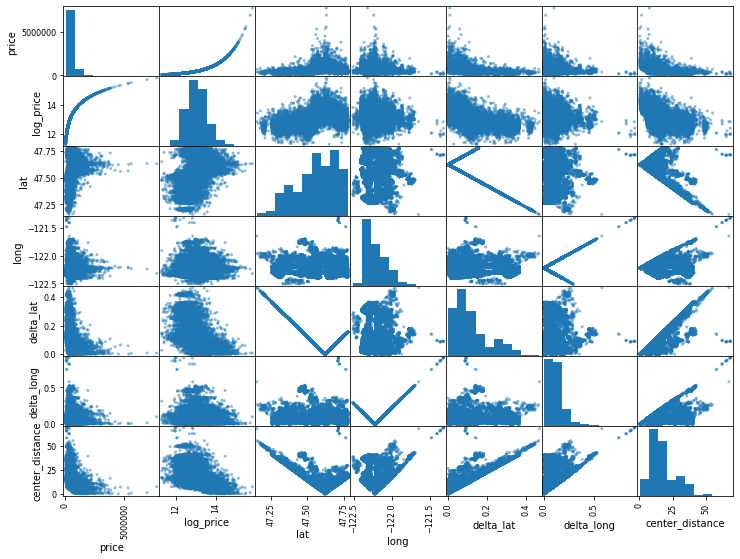

In [167]:
scatter_matrix(train_set[['price','log_price','lat','long','delta_lat','delta_long','center_distance']], figsize=(12,9));

**Conclusion:**

We will take delta_lat and delta_long instead of lat and long in the linear regression. They are better suited 
as indicators of the price due to their higher correlation with the price. The physical distance does not yield
an improvement over delta_lat. Moreover, delta_long or long are almost uncorrelated with the price, so we can 
probably drop it.

### Water distance

Let us look at the proximity to water as another parameter that may influence the price. 
In the above plot of the log_price, one can see that there is a tendency towards increasing house prices
if one approaches the water, especially near Lake Washington. This is also illustrated in the 
following scatter plots, which show the location of the houses with waterfront = 0 or 1 for each 
quartil of the house prices:

In [171]:
train_set[['price']].describe()

,price
count,1.727800e+04
mean,5.415047e+05
std,3.689629e+05
min,7.800000e+04
25%,3.238500e+05
50%,4.500000e+05
75%,6.453750e+05
max,7.700000e+06


In [172]:
very_expensive_train_set = train_set.query('price > 645000')
expensive_train_set = train_set.query('price>450000 and price<=645000')
cheap_train_set = train_set.query('price >324000 and price <= 450000')
very_cheap_train_set = train_set.query('price<=324000')

[-122.6, -121.2, 47.1, 47.8]

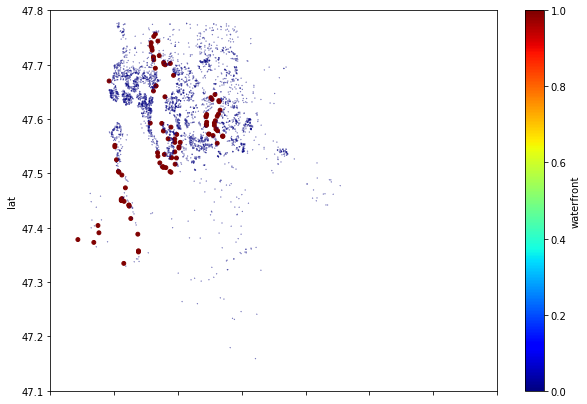

In [174]:
very_expensive_train_set.plot(kind = 'scatter', x='long', y='lat', 
                                 s= 15*(very_expensive_train_set['waterfront'])+0.05, 
                                 c='waterfront', figsize=(10,7),
                                 cmap=plt.get_cmap("jet"), colorbar=True)
plt.axis([-122.6,-121.2,47.1,47.8])

[-122.6, -121.2, 47.1, 47.8]

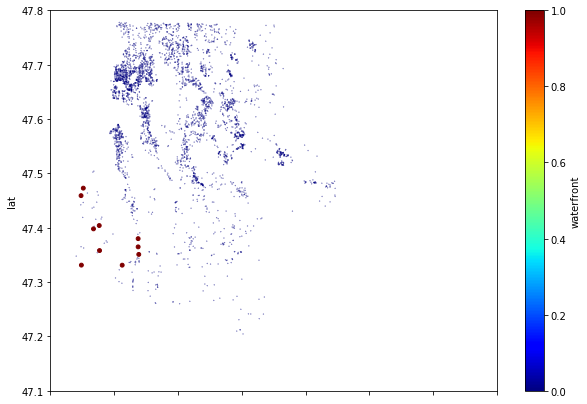

In [175]:
expensive_train_set.plot(kind='scatter', x='long', y='lat', s=15*(expensive_train_set['waterfront'])+0.05,
                            c='waterfront', figsize=(10,7), cmap=plt.get_cmap("jet"), colorbar=True)
plt.axis([-122.6, -121.2, 47.1, 47.8])

[-122.6, -121.2, 47.1, 47.8]

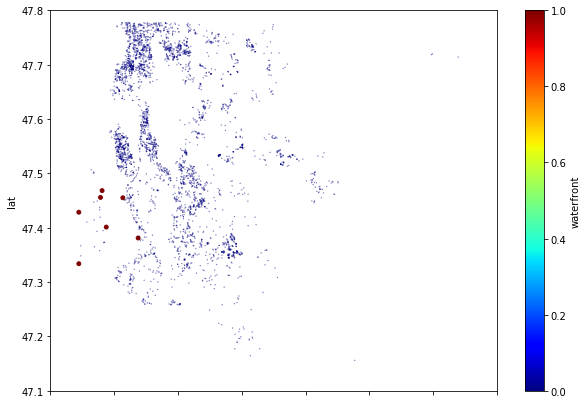

In [176]:
cheap_train_set.plot(kind='scatter', x='long', y='lat', s=15*(cheap_train_set['waterfront'])+0.05,
                            c='waterfront', figsize=(10,7), cmap=plt.get_cmap("jet"), colorbar=True)
plt.axis([-122.6, -121.2, 47.1, 47.8])

[-122.6, -121.2, 47.1, 47.8]

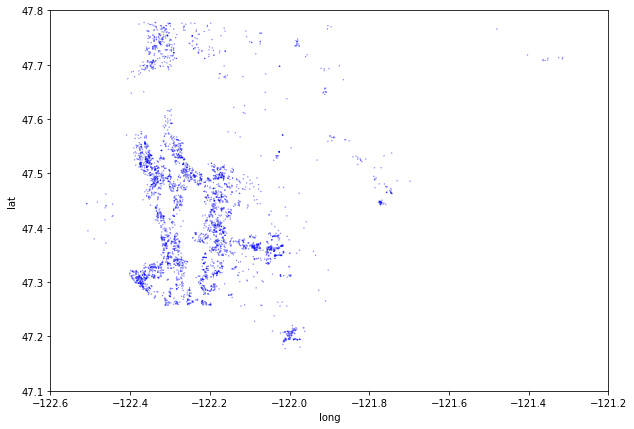

In [179]:
very_cheap_train_set.plot(kind='scatter', x='long', y='lat', s=15*(very_cheap_train_set['waterfront'])+0.05,
                           c='blue',  figsize=(10,7))
                          #cmap=plt.get_cmap("jet"), colorbar=True)
plt.axis([-122.6, -121.2, 47.1, 47.8])

From this, one can see three things:

    - The very expensive houses are mainly concentrated in the north around Lake Washington or Lake Sammamish. 
    The cheaper houses are less concentrated near Lake Washington and tend to be more spread out and 
    more in the south (We know this already from our above analysis).
    
    - The fraction of houses with waterfront = 1 decreases as the houses become cheaper.
    
    - Not all houses with waterfront = 1 are expensive or very expensive. The cheap houses with 
    waterfront =1, however,  are near Vashon Island and not near Lake Washington or Lake Sammamish.

In the following we try to construct a measure for water proximity. To this end, we extract the list 
of houses with waterfront =1 and call it water_list. We then compute for each house the minimal distance to
a member of the water_list. This minimal distance we call water_distance. This is not completely accurate, 
as the set of houses in water_list does not trace out all coasts, but we do not have better data. 

In [180]:
# dist computes the distance in km to a reference location. Input: long and lat of 
# the location of interest and ref_long and ref_lat as the long and lat of the reference location
def dist(long, lat, ref_long, ref_lat):
    delta_long = long - ref_long
    delta_lat = lat - ref_lat
    delta_long_corr = delta_long * np.cos(np.radians(ref_lat))
    return ((delta_long_corr)**2 +(delta_lat)**2)**(1/2)*2*np.pi*6378/360

#Test: Entfernung Frankfurt-Berlin:
dist(8.678,50.111, 13.383,52.531)
    

417.2328123165846

In [184]:
# The list of houses with waterfront = 1:
water_list= train_set.query('waterfront ==1')
water_list.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month,delta_lat,delta_long,center_distance
49,822039084,3/11/2015,1350000.0,3,2.50,2753,65005,1.0,1.0,2.0,...,72513,14.115615,7.680176,7.920447,7.893572,6.195169,3,0.2178,0.228,29.672498
18776,1925069066,6/23/2014,1700000.0,3,2.75,2810,18731,2.0,1.0,4.0,...,14810,14.346139,7.940940,7.940940,8.045588,6.405199,6,0.0142,0.130,9.881148
18833,7631800110,9/18/2014,380000.0,3,2.50,1980,17342,2.0,1.0,4.0,...,17313,12.847927,7.365180,7.590852,7.630461,5.257074,9,0.1668,0.150,21.712274
11832,2623039082,2/18/2015,770000.0,3,3.50,2050,21744,2.0,1.0,4.0,...,12200,13.554146,7.467371,7.625595,7.740664,5.928551,2,0.1683,0.153,21.971996
10454,333100295,11/24/2014,3120000.0,3,3.50,4490,56609,2.0,1.0,4.0,...,51330,14.953344,8.409608,8.409608,7.904704,6.543736,11,0.0778,0.017,8.753895


In [185]:
water_list.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_price_per_sqft_living,month,delta_lat,delta_long,center_distance
count,1.180000e+02,1.180000e+02,118.000000,118.000000,118.000000,118.000000,118.000000,118.0,117.000000,118.000000,...,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,4.208762e+09,1.712774e+06,3.398305,2.743644,3259.118644,25443.593220,1.648305,1.0,3.794872,3.593220,...,22602.542373,14.168259,7.725113,7.978971,7.858844,6.189288,7.008475,0.113178,0.108492,16.046415
std,2.846854e+09,1.000525e+06,1.110477,1.110585,1511.914449,48880.218741,0.559721,0.0,0.549898,0.742337,...,24679.954610,0.643381,0.475055,0.490379,0.331331,0.351551,3.114608,0.080001,0.076693,8.924241
min,1.210290e+08,3.400000e+05,1.000000,0.750000,720.000000,1989.000000,1.000000,1.0,1.000000,2.000000,...,3230.000000,12.736701,6.327937,6.579251,6.620073,4.977574,1.000000,0.005600,0.001000,2.509440
25%,1.925069e+09,9.499625e+05,3.000000,2.062500,2122.500000,10939.250000,1.000000,1.0,4.000000,3.000000,...,11678.000000,13.764178,7.380865,7.660348,7.700717,5.958303,4.250000,0.049600,0.037000,9.690406
50%,3.384676e+09,1.600000e+06,3.000000,2.500000,2995.000000,16996.500000,2.000000,1.0,4.000000,3.000000,...,15944.000000,14.285514,7.738486,8.004698,7.904704,6.248024,7.000000,0.093400,0.112000,12.410389
75%,7.351950e+09,2.282500e+06,4.000000,3.250000,4127.500000,25309.750000,2.000000,1.0,4.000000,4.000000,...,22729.000000,14.640693,8.091758,8.325427,8.070847,6.466827,10.000000,0.169350,0.153000,22.347019
max,9.536600e+09,5.300000e+06,6.000000,6.750000,9640.000000,505166.000000,3.000000,1.0,4.000000,5.000000,...,192268.000000,15.483217,8.660427,9.173676,8.499640,6.684612,12.000000,0.290800,0.291000,38.671010


In [ ]:
train_set.iloc[7:8,[29]].head()

In [254]:
#defining the column water_distance as minimal distance to a member of water_list. 
#Unfortunately, this takes a long time to process. There is  probably a better way to code this.
train_set['water_distance']=0
for i in range(len(train_set)):
    train_set.iloc[i,30]=min([dist(train_set.iloc[i,18],train_set.iloc[i,17],x,y)for (x,y) 
                              in zip(list(water_list['long']), list(water_list['lat']))])


/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [256]:
corr_matrix = train_set.corr()
corr_matrix['log_price'].sort_values(ascending=False)

log_price                    1.000000
price                        0.892266
grade                        0.703895
sqft_living                  0.695353
log_sqft_living              0.674826
sqft_living15                0.622665
log_price_per_sqft_living    0.612007
log_sqft_living15            0.610472
sqft_above                   0.600866
log_sqft_above               0.585529
bathrooms                    0.553087
lat                          0.449000
view                         0.349581
bedrooms                     0.347753
floors                       0.312087
waterfront                   0.185843
yr_renovated                 0.120596
sqft_lot                     0.103463
sqft_lot15                   0.091235
yr_built                     0.072492
long                         0.046267
condition                    0.042343
delta_long                   0.020108
id                          -0.002749
month                       -0.018302
zipcode                     -0.033888
water_distan

water_distance is thus a better indicator than waterfront, so that we will use it for linear regression.

### Other interesting observations:

Old buildings and new buildings are distributed in a way that presumably reflects the history of settlement:

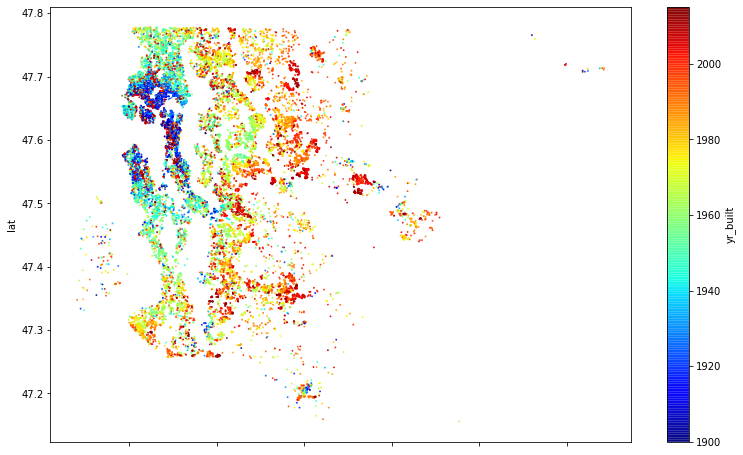

In [249]:


train_set.plot(kind='scatter', x= 'long', y= 'lat', alpha = 0.8, figsize=(13,8), s=0.8, c='yr_built', cmap=plt.get_cmap("jet"), colorbar=True);

In fact. there is a correlation between longitude and yr_built from which one can almost read 
off the frontiers of settlement:

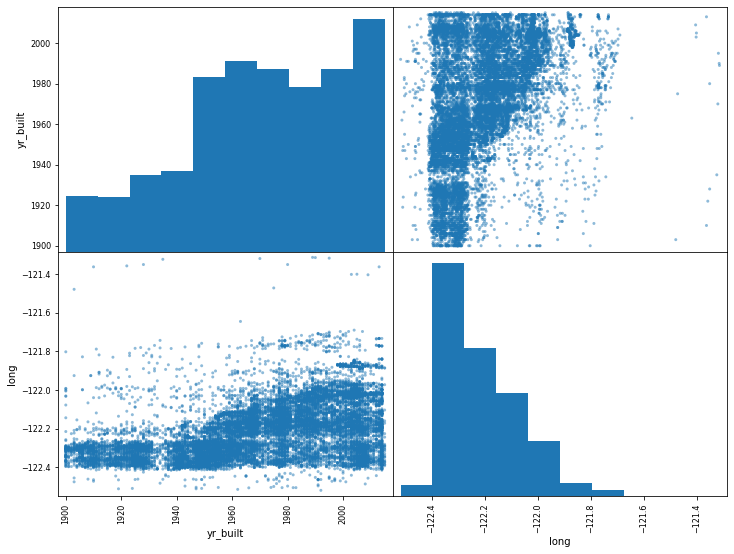

In [246]:
scatter_matrix(train_set[['yr_built', 'long']], figsize = (12,9));

The price per surface area (here: sqft_living) also follows the pattern of the price, i.e. if one needs large surface area for
little money, one should stay away from Bellevue and go south:

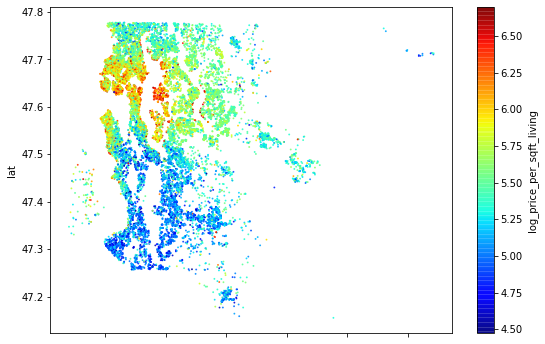

In [271]:
train_set.plot(kind='scatter', x= 'long', y= 'lat', alpha = 0.8, figsize=(9,6), s=0.8, c='log_price_per_sqft_living', cmap=plt.get_cmap("jet"), colorbar=True);

Renovated buildings are mostly where also the oldest buildings are:

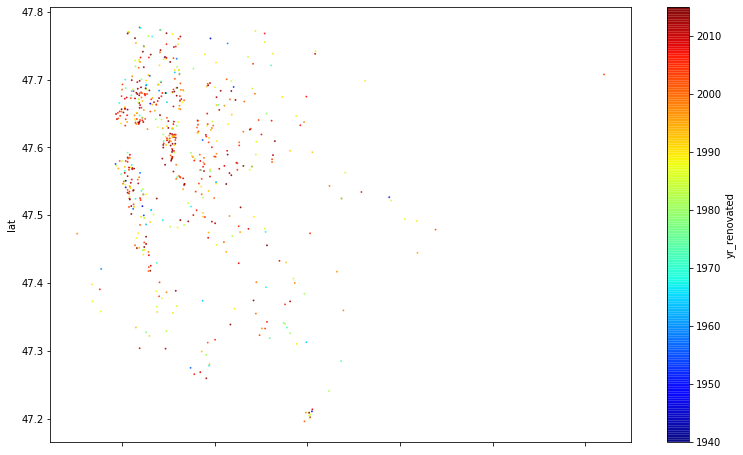

In [252]:


train_set[train_set['yr_renovated']!=0].plot(kind='scatter', x= 'long', y= 'lat', alpha = 0.8, figsize=(13,8), s=0.8, c='yr_renovated', cmap=plt.get_cmap("jet"), colorbar=True)

The highest grades have a concentration in Issaquah, where the prices are not the highest:

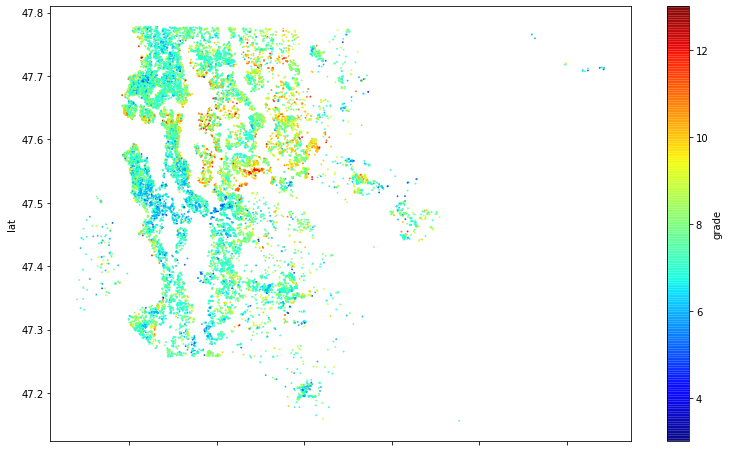

In [253]:
train_set.plot(kind='scatter', x= 'long', y= 'lat', alpha = 0.8, figsize=(13,8), s=0.8, c='grade', cmap=plt.get_cmap("jet"), colorbar=True)

Is there a seasonal variation in the price, because there is a seasonal variation in transactions? In February it is slightly cheaper than in April:

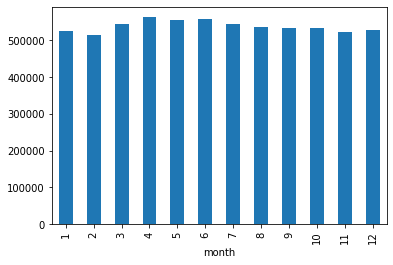

In [267]:
train_set.groupby('month')['price'].mean().plot(kind ='bar');

## Linear Regression

We take log_price as the variable to determine and take delta_lat instead of lat as well as water_distance instead of 
waterfront. We take variables with a certain minimum R. The R^2 value is 0.81 and the F_statistic 3372.

In [264]:
model = 'log_price ~ grade +  sqft_living + sqft_living15 + sqft_above + bathrooms  + delta_lat + view + bedrooms + floors + waterfront + yr_renovated + sqft_lot +    sqft_lot15 + water_distance + condition + yr_built'
# + long + zipcode'
smf.ols(formula = model, data = train_set).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     3372.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        05:32:46   Log-Likelihood:                 708.30
No. Observations:               12631   AIC:                            -1383.
Df Residuals:                   12614   BIC:                            -1256.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.5719      0.202     77.094      0.000      15.176      15.968
grade              0.1360      0.003     41.918      0.000       0.130       0.142
sqft_living        0.0001   6.51e-06     21.550      0.000       0.000       0.000
sqft_living15   8.283e-05   5.06e-06     16.380      0.000    7.29e-05    9.27e-05
sqft_above      1.892e-05    6.4e-06      2.958      0.003    6.39e-06    3.15e-05
bathrooms          0.0593      0.005     12.084      0.000       0.050       0.069
delta_lat         -2.5802      0.028    -92.838      0.000      -2.635      -2.526
view               0.0570      0.003     17.948      0.000       0.051       0.063
bedrooms          -0.0078      0.003     -2.655      0.008      -0.014      -0.002
floors             0.0191      0.005      3.565      0.000       0.009       0.030
waterfront         0.4180      0.026     16.046      0.000       0.367       0.469
yr_renovated    4.466e-05   5.49e-06      8.132      0.000    3.39e-05    5.54e-05
sqft_lot         5.58e-07   7.23e-08      7.714      0.000    4.16e-07       7e-07
sqft_lot15     -1.596e-07   1.06e-07     -1.501      0.133   -3.68e-07    4.87e-08
water_distance     0.0038      0.000      8.791      0.000       0.003       0.005
condition          0.0707      0.003     20.338      0.000       0.064       0.078
yr_built          -0.0021      0.000    -20.172      0.000      -0.002      -0.002
==============================================================================
Omnibus:                      509.833   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1279.227
Skew:                          -0.210   Prob(JB):                    1.66e-278
Kurtosis:                       4.501   Cond. No.                     4.95e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## What remains to be done:

- More accurate statistical analysis of the regression, take out some less significant variables.
- apply to test_set
- Make better use of some of the variables not studied in detail here.